# Fuzzy Suitability Analysis
This notebook 
* calculate Euclidean distances based on criteria
* assign fuzzy membership 
* conduct fuzzy overlay (AND operator)
* filter suitable areas of interest based on 1. defined memebership degree cut-off value, 2. size of areas
* save the GeoDataFrame of polygons of suitable areas and labels of polygons as list (set P)

Note: There are still two parts that need to be figured out:
1. Select land use by categories - only land use types that are acceptable for building digesters should be in the fuzzy analysis. 
2. Including digester scale in the filter of suitable areas by size and how to represent that.

In [52]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import numpy as np
from scipy import ndimage
from cflp_function import store_data_to_pickle

from rasterio.features import shapes
from rtree import index
from shapely.geometry import Point, Polygon, MultiPolygon, LineString

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt

In [35]:
%matplotlib inline

## 1. Load data

Small digester criteria:
* Proximity to farm 
* Proximity to road network

In [5]:
farm = gpd.read_file(r"./farm_new.shp")
farm.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (6.76584 52.31414)
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507950,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,558.0,POINT (6.83725 52.42508)
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507953,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,559.0,POINT (6.85936 52.38622)
3,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507962,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,560.0,POINT (6.75348 52.43438)
4,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507964,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,561.0,POINT (6.48408 52.24362)


In [6]:
farm = farm.to_crs("EPSG:28992")

In [7]:
road = gpd.read_file(r"./osm_network/G_e.shp")
road.head()

,u,v,key,highway,geometry
0,0,1,0,primary,"LINESTRING (732329.118 6863326.894, 732282.965..."
1,0,2,0,primary,"LINESTRING (732329.118 6863326.894, 732424.976..."
2,1,0,0,primary,"LINESTRING (732029.302 6862992.539, 732169.520..."
3,1,491,0,primary,"LINESTRING (732029.302 6862992.539, 731998.678..."
4,2,3,0,motorway_link,"LINESTRING (732826.405 6863768.536, 732776.088..."


In [8]:
road = road.to_crs("EPSG:28992")

In [47]:
# Load raster data
with rasterio.open(r'./raster/agri_twente.tif') as src:
    print(src.meta)
    LU = src.read(1)  # Assuming it is a single band raster

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 5073, 'height': 4185, 'count': 1, 'crs': CRS.from_epsg(28992), 'transform': Affine(10.0, 0.0, 219069.6719999984,
       0.0, -10.0, 501578.0309999995)}


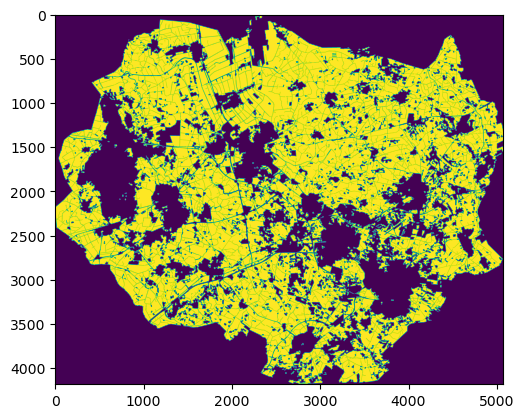

<Axes: >

In [48]:
show(LU)

In [49]:
LU.shape

(4185, 5073)

## 2. Calculate Euclidean Distances


In [13]:
# # Initialize an empty array to store the distances
# distances_farm = np.ones_like(LU) * np.inf

In [14]:
# # Iterate through each cell
# for row in range(LU.shape[0]):
#     for col in range(LU.shape[1]):
#         cell_center = src.xy(row, col)
#         point = Point(cell_center)

#         # Calculate distances to farms
#         for _, f in farm.iterrows():
#             distance = point.distance(f.geometry)
#             if distance < distances_farm[row, col]:
#                 distances_farm[row, col] = distance

In [15]:
# distances_farm.shape

In [16]:
# # Combine the distances with the original raster data
# combined_raster = LU + distances_farm

# # Visualize the combined raster
# plt.imshow(combined_raster, cmap='viridis')
# plt.colorbar()
# plt.show()

### Rtree method

In [10]:
# Create spatial indexes for farms and roads
idx_farms = index.Index()
for i, f in farm.iterrows():
    idx_farms.insert(i, f.geometry.bounds)

In [44]:
# Create a mask to identify non-zero values, the cells with zero are background cells
background_value = 0  # Adjust this if the background value is different
mask = LU != background_value

In [45]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [12]:
# Create new array in the shape of LU and fill with inf values 
distance_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [13]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)
        # Calculate distances to nearby farms using spatial indexing
            for j in idx_farms.nearest(cell_center, 1):
                f = farm.geometry.iloc[j]
                d = point.distance(f)
                if d < distance_to_farm[row, col]:
                    distance_to_farm[row, col] = d

In [14]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/distance_to_farm_complete_rtree.tif', 'w', **profile) as dst:
        dst.write(distance_to_farm, 1)

In [105]:
# (distances_farm==distances_f).all() 

True

In [18]:
# Convert farm geometries to NumPy array
farm_points = np.array([(geom.x, geom.y) for geom in farm.geometry])

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(farm_points)

# Create new array in the shape of LU and fill with inf values 
d_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [19]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]:  # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

            # Use the KDTree to find the index of the nearest farm
            j = tree.query([cell_center], k=1)[1][0]

            f = farm.geometry.iloc[j]
            d = point.distance(f)

            if d < d_to_farm[row, col]:
                d_to_farm[row, col] = d

cKDTree is 26 min (d to farm), Rtree is 117min (distance to farm). 

In [20]:
# Check if the arrays are equal
are_equal = np.array_equal(distance_to_farm, d_to_farm)

if are_equal:
    print("The arrays are equal.")
else:
    print("The arrays are not equal.")

The arrays are equal.


In [31]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_farm_complete_ckdtree.tif', 'w', **profile) as dst:
        dst.write(d_to_farm, 1)

In [15]:
new_raster = np.copy(d_to_farm_raster)

In [16]:
new_raster[np.isinf(new_raster)] = 0

In [17]:
new_raster

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/raster_test.tif', 'w', **profile) as dst:
        dst.write(new_raster, 1)

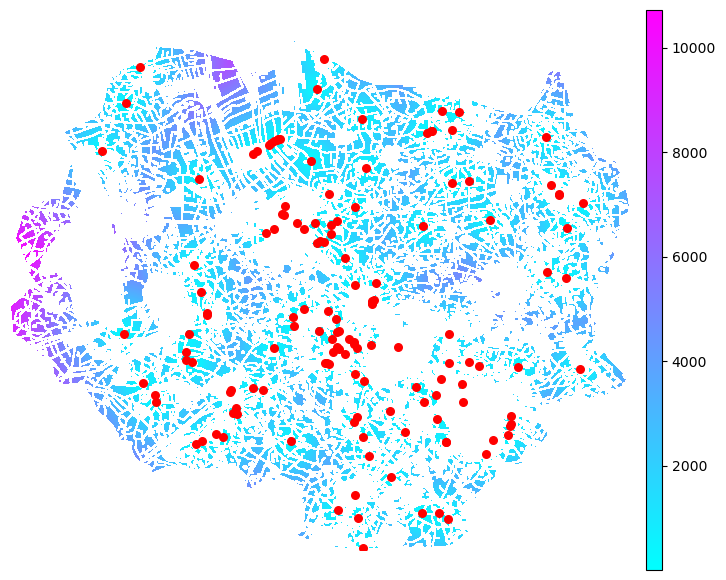

In [42]:
with rasterio.open(r'./raster/d_to_farm_complete_ckdtree.tif') as src_farm:

    d_to_farm_raster = src_farm.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_farm, ax=ax, cmap= 'cool')

    # Plot the farms
    farm.plot(ax=ax, marker='o', color='red', markersize=30)
    # road.plot(ax=ax)

    # # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')

    # Show the plot
    plt.savefig('./raster/new_raster.png', dpi=1000)
    plt.show()

In [30]:
# Check if the arrays are equal
are_equal = np.array_equal(distance_to_farm, d_to_farm)

if are_equal:
    print("The arrays are equal.")
else:
    print("The arrays are not equal.")

The arrays are equal.


### Distance to Road

In [46]:
# Create spatial indexes for roads
idx_roads = index.Index()
for i, r in road.iterrows():
    idx_roads.insert(i, r.geometry.bounds)

In [45]:
d_to_road = np.full_like(LU, np.inf, dtype=np.float64)

# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]: # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

        # Calculate distances to nearby farms using spatial indexing
            for j in idx_roads.nearest(cell_center, 1):
                r = road.geometry.iloc[j]
                d = point.distance(r)
                if d < d_to_road[row, col]:
                    d_to_road[row, col] = d

In [ ]:
# Convert farm geometries to NumPy array
farm_points = np.array([(geom.x, geom.y) for geom in farm.geometry])

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(farm_points)

# Create new array in the shape of LU and fill with inf values 
d_to_farm = np.full_like(LU, np.inf, dtype=np.float64)

In [ ]:
# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]:  # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

            # Use the KDTree to find the index of the nearest farm
            j = tree.query([cell_center], k=1)[1][0]

            f = farm.geometry.iloc[j]
            d = point.distance(f)

            if d < d_to_farm[row, col]:
                d_to_farm[row, col] = d

In [54]:
# Convert road geometries to NumPy array
road_lines = np.concatenate([np.array(line.coords) for line in road.geometry])

# Create a KDTree for fast nearest-neighbor search
tree = cKDTree(road_lines)

In [57]:
# Create a new array in the shape of LU and fill with inf values
d_to_road = np.full_like(LU, np.inf, dtype=np.float64)

# Iterate through each cell
for row in range(LU.shape[0]):
    for col in range(LU.shape[1]):
        if mask[row, col]:  # Check the mask to exclude background values
            cell_center = src.xy(row, col)
            point = Point(cell_center)

            # Use the KDTree to find the index of the nearest road point
            j = tree.query([cell_center], k=1)[1][0]

            # Extract the coordinates of the nearest road point
            road_point_coords = road_lines[j]

            # Convert the road point coordinates to a Shapely Point
            road_point = Point(road_point_coords)

            # Calculate the distance from the raster cell to the nearest road point
            d = point.distance(road_point)

            # Update the distance array if the calculated distance is smaller
            if d < d_to_road[row, col]:
                d_to_road[row, col] = d

In [46]:
d_to_road

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [58]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/d_to_road_complete_ckdtree.tif', 'w', **profile) as dst:
        dst.write(d_to_road, 1)

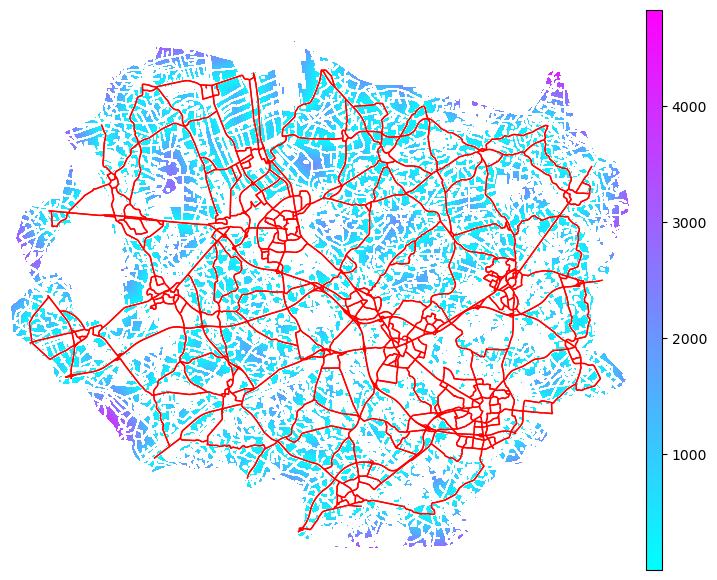

In [64]:
with rasterio.open(r'./raster/d_to_road_complete_ckdtree.tif') as src_road:

    d_to_road_raster = src_road.read(1)
    
    # Plot the raster
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src_road, ax=ax, cmap='cool')

    # Plot the farms
    road.plot(ax=ax, color='red', linewidth=1)

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    
    plt.savefig('./raster/d_to_road_complete_ckdtree.png', dpi=1200)

    # Show the plot
    plt.show()

## 2. Fuzzy Membership

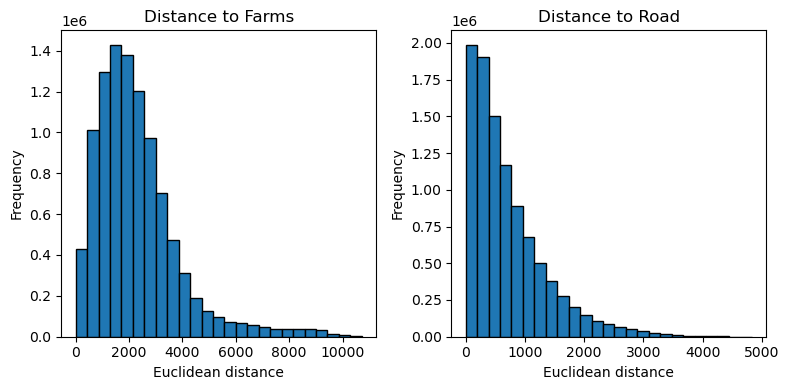

In [66]:
# Create subplots
plt.figure(figsize=(8, 4))

# Plot the first histogram
plt.subplot(1, 2, 1)
plt.hist(d_to_farm_raster[np.isfinite(d_to_farm_raster)], bins=25, edgecolor='black')
plt.title('Distance to Farms')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Plot the second histogram
plt.subplot(1, 2, 2)
plt.hist(d_to_road_raster[np.isfinite(d_to_road_raster)], bins=25, edgecolor='black')
plt.title('Distance to Road')
plt.xlabel('Euclidean distance')
plt.ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [67]:
d_to_farm_range = d_to_farm_raster[np.isfinite(d_to_farm_raster)] 
d_to_road_range = d_to_road_raster[np.isfinite(d_to_road_raster)]

In [68]:
len(d_to_farm_range)

10071873

In [69]:
len(d_to_road_range)

10071873

In [70]:
fuzzy_farm = np.maximum(0, 1 - (d_to_farm_range - d_to_farm_range.min()) / (d_to_farm_range.max() - d_to_farm_range.min()))

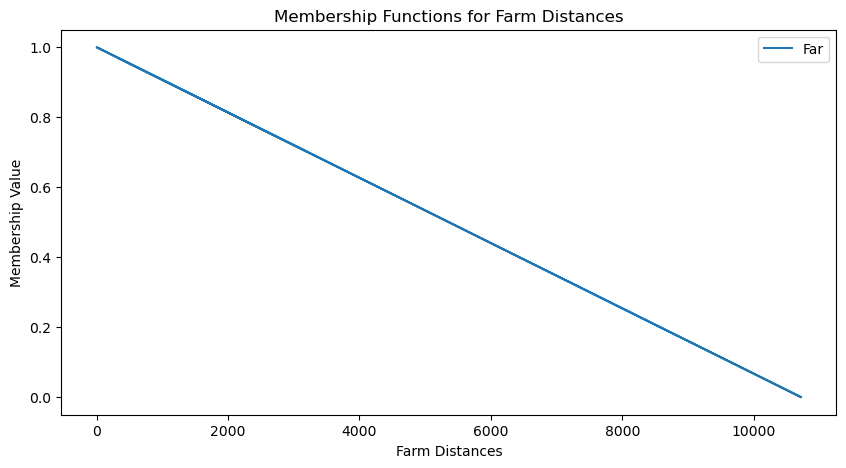

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(d_to_farm_range, fuzzy_farm, label='Far')
plt.title('Membership Functions for Farm Distances')
plt.xlabel('Farm Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

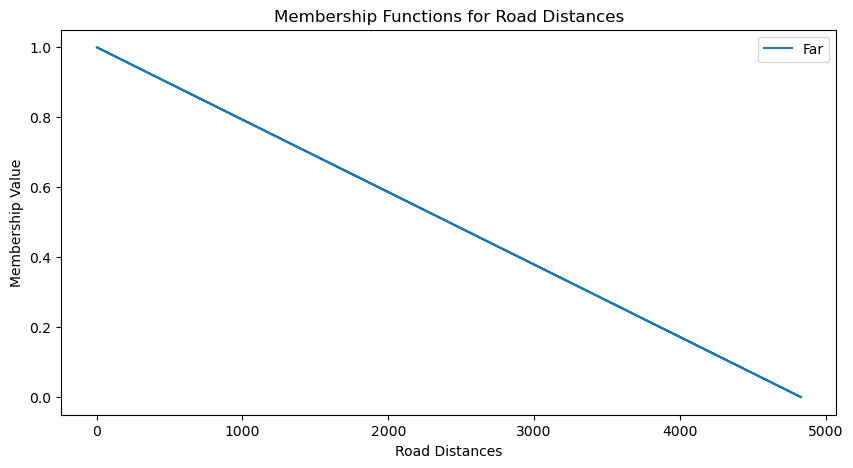

In [72]:
fuzzy_road = np.maximum(0, 1 - (d_to_road_range - d_to_road_range.min()) / (d_to_road_range.max() - d_to_road_range.min()))
plt.figure(figsize=(10, 5))
plt.plot(d_to_road_range, fuzzy_road, label='Far')
plt.title('Membership Functions for Road Distances')
plt.xlabel('Road Distances')
plt.ylabel('Membership Value')
plt.legend()
plt.show()

## 3. Fuzzy Overlay

In [73]:
# Fuzzy operation AND
fuzzy_and = np.minimum(fuzzy_farm, fuzzy_road)

The fuzzy operations are done for non-inf values in the LU raster layer. Therefore, now after the operation we need to export fuzzy array in the shape of the original raster layer.

In [74]:
# Find indices where fuzzy_and is not inf
non_inf_indices = np.where(np.isfinite(d_to_farm_raster))
non_inf_indices

(array([   0,    0,    1, ..., 4183, 4183, 4183]),
 array([2299, 2300, 2297, ..., 2852, 2853, 2854]))

In [75]:
# Check if the number of values in fuzzy array and non-inf values in original raster layer are the same
assert len(fuzzy_and) == len(non_inf_indices[0])

In [76]:
# Get a copy of the original raster array 
m = np.copy(d_to_farm_raster)

In [77]:
# Replace values in result_array with corresponding values from lu array
m[non_inf_indices] = fuzzy_and

In [78]:
# Open the original raster file
with rasterio.open(r'./raster/agri_twente.tif') as src:
    # Retrieve the metadata from the original raster file
    profile = src.profile
    # Update the metadata for the new raster file with the data from distances_farm
    profile.update(
        dtype=rasterio.float32,
        count=1
    )

    # Save the distances_farm array as a new raster file
    with rasterio.open(r'./raster/fuzzy_and_complete_1.tif', 'w', **profile) as dst:
        dst.write(m, 1)

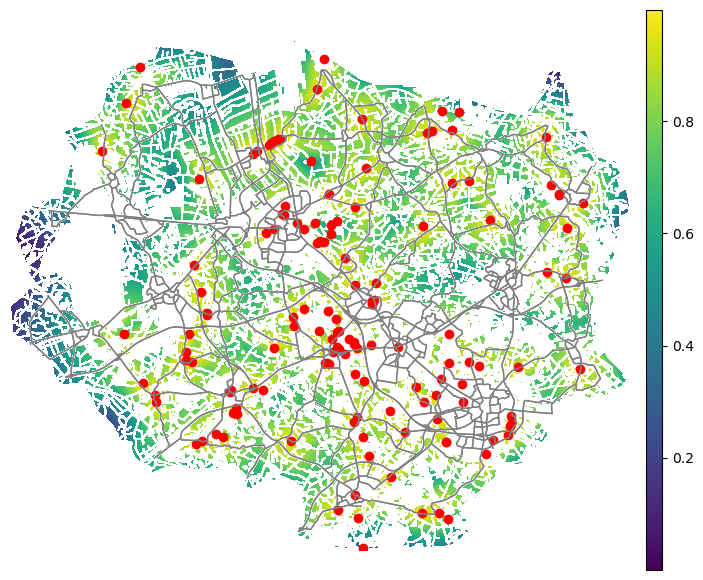

In [80]:
with rasterio.open(r'./raster/fuzzy_and_complete_1.tif') as src:

    fuzzy = src.read(1)
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    road.plot(ax=ax, color='grey', linewidth=1)
    farm.plot(ax=ax, color='red')

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    plt.savefig('./raster/fuzzy_and_complete_1.png', dpi=1200)

    ax.axis('off')
    plt.show()

## 4. Processing Suitable Areas
Now we have a raster layer that indicates how suitable a cell for building digester. We have to somehow process this data into set Plant as the CFLP model input. Set Plant should be node osmid.
* Filter by area requirement 
* Append to nodes

In [43]:
n = gpd.read_file(r"./raster/clip_node.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,391,6.852609e+06,749985.068617,6.737230,52.289324,motorway_junction,POINT (247106.336 478783.924)
1,421,6.852019e+06,750489.245723,6.741760,52.286082,motorway_junction,POINT (247422.054 478428.975)
2,422,6.853062e+06,749313.366809,6.731197,52.291813,NaN,POINT (246689.562 479053.139)
3,429,6.852456e+06,749798.452623,6.735554,52.288483,NaN,POINT (246993.714 478688.167)
4,430,6.853370e+06,749330.907112,0.000000,0.000000,NaN,POINT (246696.821 479241.477)


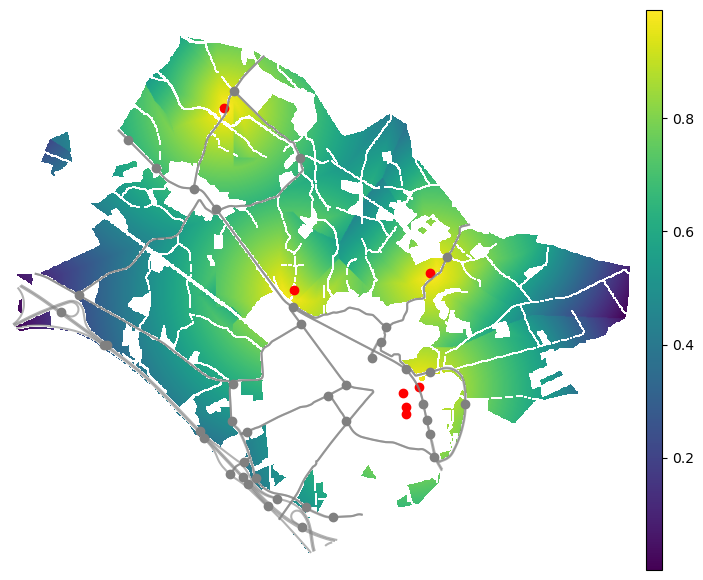

In [44]:
with rasterio.open(r'./raster/fuzzy_and_1.tif') as src:

    fuzzy = src.read(1)
    transform = src.transform
 
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)

    road.plot(ax=ax, color='grey', alpha=0.6)
    farm.plot(ax=ax, color='red')
    n.plot(ax=ax, color='grey')

    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(ax.get_images()[0], cax=cax)

    ax.axis('off')
    plt.show()

In [45]:
# Define area requirement for each scale of digester
s_area_min = 500
s_area_max = 1000 #m2, which = 1ha

In [46]:
# Define a cut off suitability value to filter areas
cut_off = 0.8

In [48]:
# Create a binary mask based on the cut_off values
mask = ((fuzzy >= cut_off) & np.isfinite(fuzzy))

# Connect the raster cells in mask based on adjacency 
label_map, num_labels = ndimage.label(mask) # num_labels - the total number of labels or connected components found in the binary mask.
    # adjacent elements along any dimension are considered connected
    # ndimage.label is a powerful tool for segmenting and identifying distinct regions in binary images, 
    # making it useful in various image processing and computer vision applications.

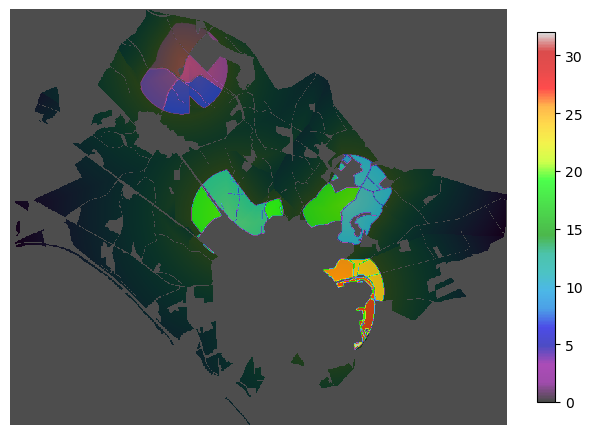

In [49]:
# Plot all areas of interest 
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none')

# Visualize the labeled components
plt.imshow(label_map, cmap='nipy_spectral', alpha=0.7)

plt.colorbar(shrink=0.6)
plt.axis('off')
plt.show()

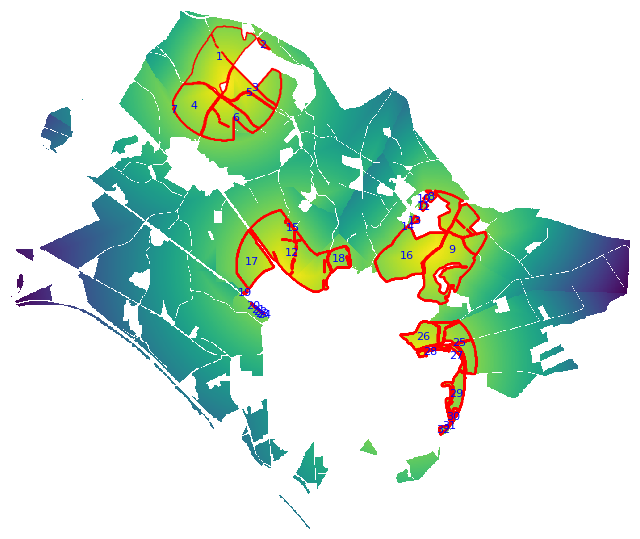

In [50]:
# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis')

# Visualize the labeled components with contours
contours = plt.contour(label_map, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# Add labels for each connected component at the centroid
for label in range(1, num_labels + 1):
    indices = np.argwhere(label_map == label)
    centroid = np.mean(indices, axis=0)
    plt.text(centroid[1], centroid[0], str(label), color='blue', fontsize=8, ha='center', va='center')

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

In [51]:
# Calculate the area of each labeled component
area_sizes = ndimage.sum(mask, label_map, range(num_labels + 1))

# Identify areas meeting the size criteria
valid_areas = np.where((area_sizes >= s_area_min) & (area_sizes <= s_area_max))[0]

# Create a mask for the valid areas
valid_areas_mask = np.isin(label_map, valid_areas)
np.any(valid_areas_mask) # sometime there could be that none of the component meets the criteria

True

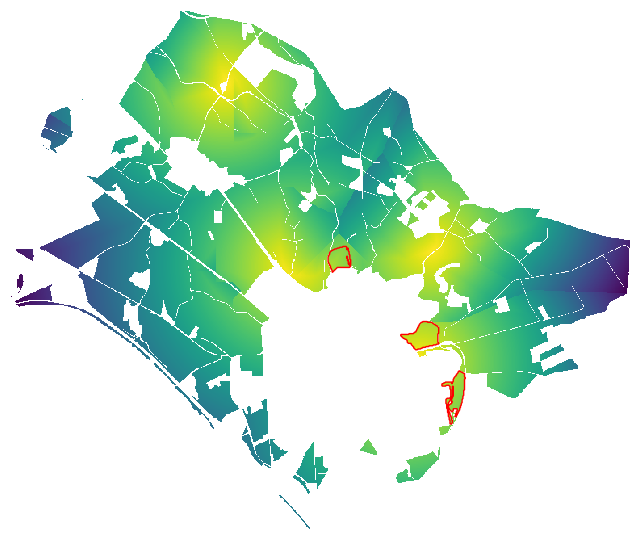

In [52]:
# Plot all areas of interest that fit the area requirement 

# Set the figure size
plt.figure(figsize=(8, 8))

# Visualize the original raster
plt.imshow(fuzzy, interpolation='none', cmap='viridis', zorder=1)

# Visualize the labeled components with contours
contours = plt.contour(valid_areas_mask, levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1)

# # Customize the colorbar
# colorbar = plt.colorbar(shrink=0.8)

# Remove the axis ticks
plt.axis('off')

plt.show()

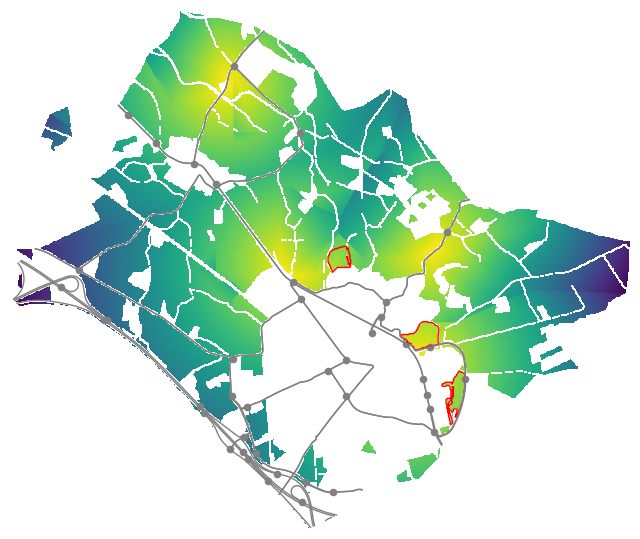

In [53]:
with rasterio.open('./raster/fuzzy_and_1.tif') as src:
    fuzzy = src.read(1)
    transform = src.transform

    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the raster using imshow
    ax.imshow(fuzzy, cmap='viridis', extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Plot contours ([::-1, :] to flip the array vertically before plotting)
    contours = plt.contour(valid_areas_mask[::-1, :], levels=np.arange(0.5, num_labels + 0.5, 1), colors='red', linewidths=1, extent=[src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top])

    # Plot the GeoDataFrame
    n.plot(ax=ax, color='grey', markersize = 20)
    road.plot(ax=ax, color='grey', zorder=2, linewidth =1)

    ax.axis('off')
    plt.show()

## 5. Prepare identified suitable areas as CFLP model inputs (set Plant)
Outputs:
* set Plant
* GeoDataFrame of polygons of suitable areas for OD matrix calculation

In [54]:
label_component, num_labels_component = ndimage.label(valid_areas_mask)

In [55]:
polygons = []
# Iterate through each label and convert it to a polygon
for label in range(1, num_labels_component + 1):
    mask = label_component == label
    shape_info = next(shapes(mask.astype(np.uint8), mask=mask, transform=transform))
    # Extract each set of coordinates and create a Shapely Polygon
    coordinates_list = shape_info[0]['coordinates']
    polygons.append((label, MultiPolygon([Polygon(coords) for coords in coordinates_list])))

In [56]:
polygons

[(1,
  <MULTIPOLYGON (((247919.672 481598.031, 247919.672 481588.031, 247879.672 48...>),
 (2,
  <MULTIPOLYGON (((248909.672 480668.031, 248909.672 480658.031, 248889.672 48...>),
 (3,
  <MULTIPOLYGON (((249359.672 480058.031, 249359.672 480048.031, 249349.672 48...>)]

In [57]:
# Create a GeoDataFrame from the list of polygons
polygon_gdf = gpd.GeoDataFrame(polygons, columns=['Label', 'Coordinates'], geometry='Coordinates', crs=n.crs)

<Axes: >

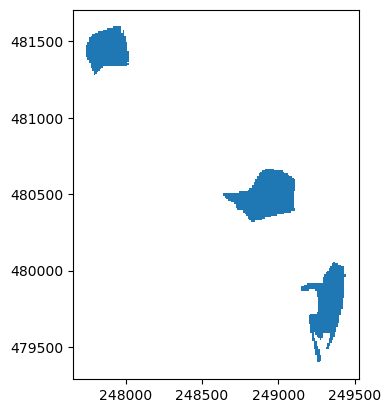

In [58]:
polygon_gdf.plot()

Maybe it is not necessary to get polygons of suitable areas. A centroid will suffice for finding nearest node. But perhaps polygon is nice for visualization. 

In [24]:
# Export GeoDataFrame
polygon_gdf.to_file(r'./raster/suitable_polygons_gdf.shp')

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_51213/1851650195.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygon_gdf.to_file(r'./raster/suitable_polygons_gdf.shp')


In [61]:
# Export set Plant
folder_path = 'app_data'
store_data_to_pickle(polygon_gdf['Label'].tolist(), folder_path, 'Plant.pickle') # set P